# MNIST数据集下用Paddle框架的动态图模式玩耍经典对抗生成网络（GAN）

作者信息：[Liyulingyue](https://github.com/Liyulingyue)

更新日期：2022 年 11 月 18 日

## 1. 简要介绍
### 关于GAN
[GAN](https://arxiv.org/abs/1406.2661)（Generative Adversarial Networks, 对抗生成网络）是Ian J. Goodfellow等在2014年提出的一种建立生成模型的框架。在这个框架中，用于刻画目标数据的生成模型（Generative model, 下文简称G）和用于鉴别数据是否真实的鉴别模型（Discriminative model, 下文简称D）被交替训练，最终使得G能够完美刻画目标数据的分布，而D的误判率趋近于1/2。

GAN的训练框架可以描述如下：


```
1. 抽取一组真实数据
2. 根据随机数，通过G生成假数据
3. 训练鉴别器D
4. 将生成数据输入D，将D的输出和正标签求loss
5. 根据第四步的loss更新G
6. 重复第一到第五步直到收敛
```

### 关于MINIST
[MINIST](http://yann.lecun.com/exdb/mnist/)是一个手写数字数据集，Paddle已经集成了这个数据集，可以通过封装好的API直接获取这个数据集中的内容。

### 关于Paddle的梯度计算
Paddle动态图模式梯度计算是自动累加模式。因此，在运行GAN（对抗生成网络）的时候，可以多个batch/多个模块的loss单独进行backward，但也需要需要注意清除梯度和阻断反向传播。

关于梯度累加和阻断反向传播的介绍如下：

1. 梯度累加：梯度累加是指在模型训练过程中，训练一个 batch 的数据得到梯度后，不立即用该梯度更新模型参数，而是继续下一个 batch 数据的训练，得到梯度后继续循环，多次循环后梯度不断累加，直至达到一定次数后，用累加的梯度更新参数，这样可以起到变相扩大 batch_size 的作用。受限于显存大小，可能无法开到更大的 batch_size，使用梯度累加可以实现增大 batch_size 的作用。动态图模式天然支持梯度累加，即只要不调用梯度清零 clear_grad 方法，动态图的梯度会一直累积。
2. 阻断反向传播：在一些任务中，只希望拿到正向预测的值，但是不希望更新参数，或者在反向的时候剪枝，减少计算量，阻断反向的传播，即可使用`paddle.Tensor.detach()`产生一个新的、和当前计算图分离的，但是拥有当前变量内容的临时变量。


## 2. 环境设置
导入包，主要包括paddle和一些画图辅助，如plt





In [8]:
import os
import random
import paddle 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2

# 输出使用的paddle版本
print(paddle.__version__)

2.3.2


## 3. 数据集
Paddle已经集成MNIST数据集了，直接调用即可。本项目通过`paddle.vision.datasets.MNIST`导入数据集，并且用paddle.io.DataLoader封装为读取器。

如果想要换成其他数据集，可以自行参考如何使用`paddle.io.Dataset`和`paddle.io.DataLoader`，封装后即可轻松复用本项目代码进行训练。

首先，加载数据集。

In [ ]:
dataset = paddle.vision.datasets.MNIST(mode='train', 
                                        transform=paddle.vision.transforms.Compose([
                                            paddle.vision.transforms.Resize((32,32)),
                                            paddle.vision.transforms.Normalize([0], [255])
                                        ]))

dataloader = paddle.io.DataLoader(dataset, batch_size=32,shuffle=True, num_workers=4)

查看数据的形状，可以看到从dataloader返回的数据格式中，每张图大小为32*32，每张图片带有一个标签。

In [3]:
for step, data in enumerate(dataloader):
    data, label = data
    print(step, data.shape, label.shape)
    break

0 [32, 1, 32, 32] [32, 1]


查看一张图片。

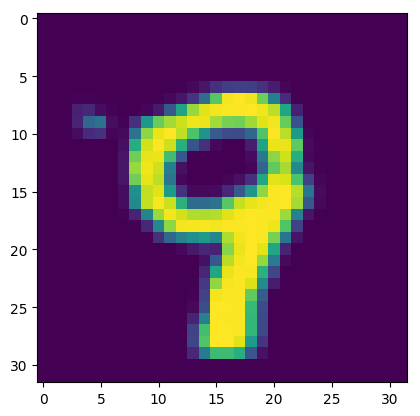

In [5]:
plt.imshow(data[0].numpy()[0])
# plt.show()

通过下述代码可以快捷查看十张图片。

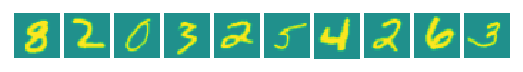

In [11]:
for i in range(10):
    image = data[i].numpy()[0]
    plt.subplot(1, 10, i + 1)

    plt.imshow(image, vmin=-1, vmax=1)
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

## 4. 模型组网
GAN是一种生成网络框架，因此，可以选用任何网络去训练生成模型，只需要保证G和D的构造是满足需求的即可。

本项目中，Generator由3个全连接层组建，用于将一个长为100的随机数向量扩充为长和宽均为32的图片。Discriminator同样由3个全连接层组成，用于将一张图片转化为数字，1表明这张图片是真实的，0表示这张图片是由网络生成的。

In [8]:
# Generator Code
class Generator(paddle.nn.Layer):
    def __init__(self, ):
        super(Generator, self).__init__()
        self.gen = paddle.nn.Sequential(
            paddle.nn.Linear(in_features=100, out_features=256),
            paddle.nn.ReLU(True),
            paddle.nn.Linear(in_features=256, out_features=512),
            paddle.nn.ReLU(True),
            paddle.nn.Linear(in_features=512, out_features=1024),
            paddle.nn.Tanh(),
        )

    def forward(self, x):
        x = self.gen(x)
        out = paddle.reshape(x,[-1,1,32,32])
        return out

# 创建模型
netG = Generator()
print(netG)

# 通过paddle.summary可以查看一个指定形状的数据在网络中各个模块中的传递
paddle.summary(netG, (8, 100))

Generator(
  (gen): Sequential(
    (0): Linear(in_features=100, out_features=256, dtype=float32)
    (1): ReLU(name=True)
    (2): Linear(in_features=256, out_features=512, dtype=float32)
    (3): ReLU(name=True)
    (4): Linear(in_features=512, out_features=1024, dtype=float32)
    (5): Tanh()
  )
)
---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Linear-2          [[8, 100]]            [8, 256]           25,856     
    ReLU-1           [[8, 256]]            [8, 256]              0       
   Linear-3          [[8, 256]]            [8, 512]           131,584    
    ReLU-2           [[8, 512]]            [8, 512]              0       
   Linear-4          [[8, 512]]           [8, 1024]           525,312    
    Tanh-1          [[8, 1024]]           [8, 1024]              0       
Total params: 682,752
Trainable params: 682,752
Non-trainable params: 0
-------------------------------

{'total_params': 682752, 'trainable_params': 682752}

In [9]:
# Discriminator Code
class Discriminator(paddle.nn.Layer):
    def __init__(self, ):
        super(Discriminator, self).__init__()
        self.dis = paddle.nn.Sequential(
            paddle.nn.Linear(in_features=1024, out_features=512),
            paddle.nn.LeakyReLU(0.2),
            paddle.nn.Linear(in_features=512, out_features=256),
            paddle.nn.LeakyReLU(0.2),
            paddle.nn.Linear(in_features=256, out_features=1),
            paddle.nn.Sigmoid()
        )

    def forward(self, x):
        x = paddle.reshape(x, [-1, 1024])
        out = self.dis(x)
        return out

netD = Discriminator()
print(netD)

# 通过paddle.summary可以查看一个指定形状的数据在网络中各个模块中的传递
paddle.summary(netD, (8, 1, 32, 32))

Discriminator(
  (dis): Sequential(
    (0): Linear(in_features=1024, out_features=512, dtype=float32)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, dtype=float32)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, dtype=float32)
    (5): Sigmoid()
  )
)
---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Linear-5         [[8, 1024]]            [8, 512]           524,800    
  LeakyReLU-1        [[8, 512]]            [8, 512]              0       
   Linear-6          [[8, 512]]            [8, 256]           131,328    
  LeakyReLU-2        [[8, 256]]            [8, 256]              0       
   Linear-7          [[8, 256]]             [8, 1]              257      
   Sigmoid-1          [[8, 1]]              [8, 1]               0       
Total params: 656,385
Trainable params: 656,385
Non-trainable params: 

{'total_params': 656385, 'trainable_params': 656385}

## 5. 模型训练

本项目的训练参数配置如下：

- 迭代次数：10
- 损失函数：[均方损失函数（MSELoss）](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/nn/MSELoss_cn.html#mseloss)
- 优化器：Adam优化器，出自[Adam论文](https://arxiv.org/abs/1412.6980)的第二节，能够利用梯度的一阶矩估计和二阶矩估计动态调整每个参数的学习率。
- 学习率：0.0002

下述程序大约需要运行半个小时。



Epoch ID=0 Batch ID=100 

 D-Loss=0.3066627085208893 G-Loss=0.5891025066375732


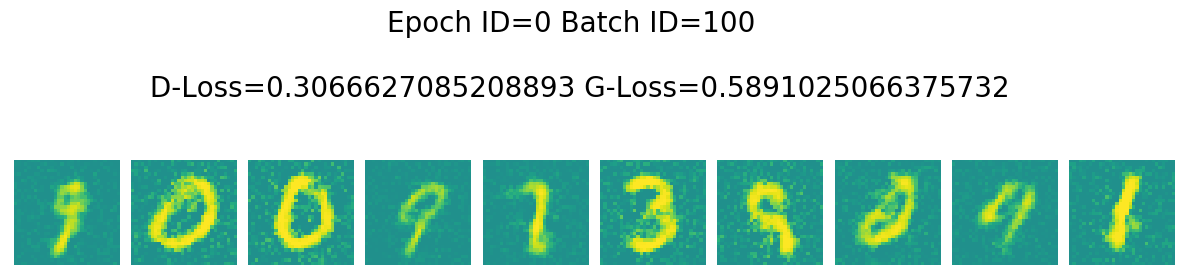

In [19]:
# create Net
netG = Generator()
netD = Discriminator()

# 如果想要接着之前训练的模型训练，将if 0修改为if 1即可
if 1:
    try:
        mydict = paddle.load('generator.params')
        netG.set_dict(mydict)
        mydict = paddle.load('discriminator.params')
        netD.set_dict(mydict)
    except:
        print('fail to load model')

optimizerD = paddle.optimizer.Adam(parameters=netD.parameters(), learning_rate=0.0002, beta1=0.5, beta2=0.999)
optimizerG = paddle.optimizer.Adam(parameters=netG.parameters(), learning_rate=0.0002, beta1=0.5, beta2=0.999)

# 最大迭代epoch
max_epoch = 10

now_step = 0
for epoch in range(max_epoch):
    for step, (data, label) in enumerate(dataloader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        # 清除D的梯度
        optimizerD.clear_grad()

        # 传入正样本，并更新梯度
        pos_img = data
        label = paddle.full([pos_img.shape[0], 1], 1, dtype='float32')
        pre = netD(pos_img)
        loss_D_1 = paddle.nn.functional.mse_loss(pre, label)
        loss_D_1.backward()

        # 通过randn构造随机数，制造负样本，并传入D，更新梯度
        noise = paddle.randn([pos_img.shape[0], 100], 'float32')
        neg_img = netG(noise)
        label = paddle.full([pos_img.shape[0], 1], 0, dtype='float32')
        pre = netD(neg_img.detach()) # 通过detach阻断网络梯度传播，不影响G的梯度计算
        loss_D_2 = paddle.nn.functional.mse_loss(pre,label)
        loss_D_2.backward()

        # 更新D网络参数
        optimizerD.step()
        optimizerD.clear_grad()

        loss_D = loss_D_1 + loss_D_2

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################

        # 清除D的梯度
        optimizerG.clear_grad()

        noise = paddle.randn([pos_img.shape[0], 100],'float32')
        fake = netG(noise)
        label = paddle.full((pos_img.shape[0], 1), 1, dtype=np.float32,)
        output = netD(fake)
        loss_G = paddle.nn.functional.mse_loss(output,label)
        loss_G.backward()

        # 更新G网络参数
        optimizerG.step()
        optimizerG.clear_grad()

        now_step += 1

        ###########################
        # 可视化
        ###########################
        if now_step % 100 == 0:
            generated_image = netG(noise).numpy()
            imgs = []
            plt.figure(figsize=(15,15))
            try:
                for i in range(10):
                    # image = generated_image[i].transpose()
                    image = generated_image[i]
                    image = np.where(image > 0, image, 0)
                    image = image.transpose((1,2,0))
                    plt.subplot(10, 10, i + 1)
                    
                    plt.imshow(image[...,0], vmin=-1, vmax=1)
                    plt.axis('off')
                    plt.xticks([])
                    plt.yticks([])
                    plt.subplots_adjust(wspace=0.1, hspace=0.1)
                msg = 'Epoch ID={0} Batch ID={1} \n\n D-Loss={2} G-Loss={3}'.format(epoch, now_step, loss_D.numpy()[0], loss_G.numpy()[0])
                print(msg)
                plt.suptitle(msg,fontsize=20)
                plt.draw()
                # 保存在work文件夹下
                plt.savefig('{}/{:04d}_{:04d}.png'.format('work', epoch, now_step), bbox_inches='tight')
                plt.pause(0.01)
            except IOError:
                print(IOError)
paddle.save(netG.state_dict(), "generator.params")
paddle.save(netD.state_dict(), "discriminator.params")

## 6. 模型预测
通过下述代码即可调用刚刚训练好的生成器。

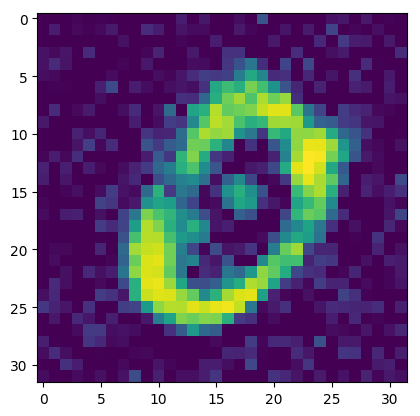

In [29]:
netG = Generator()
mydict = paddle.load('generator.params')
netG.set_dict(mydict)

noise = paddle.randn([1, 100],'float32')
img = netG(noise)
img = img.numpy()[0][0]
img[img<0] = 0
plt.imshow(img)

## 7. 结语
本文简单的用全连接网络跑通了GAN的流程，如果对网络有更高的性能需求可以参考文末的两个参考链接，内容类似，但是会更为详实。

在本文的基础上，如果删除了激活层，代码也是可以运行的，但是没有激活层的情况下，模型学习到的效果较差，因此，在构造GAN的时候需要较为慎重的选择对应的生成模型。

## 8. 致谢
本文参考以下项目
- [一文搞懂生成对抗网络之经典GAN（动态图、VisualDL2.0）](https://aistudio.baidu.com/aistudio/projectdetail/551962)
- [生成对抗网络七日打卡营](https://aistudio.baidu.com/aistudio/course/introduce/16651)

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 